# Create Project

In [1]:
#import libraries 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
import shap

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

## Functions

In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

## Load the Joblib Files

In [5]:
# load the joblib file
loaded_joblib= joblib.load('best-models.joblib')
loaded_joblib.keys()


dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [6]:
# save the objects
X_train = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
lin_reg = loaded_joblib['LinearRegression']
rf_reg = loaded_joblib['RandomForestRegressor']

In [10]:
## Get feature names from already-fit preprocessor
feature_names = preprocessor.get_feature_names_out()


## Use the preprocessor to transform X_train and X_test
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2
3527,7.855,0.000000,38.3848,1997.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
7331,19.750,0.012499,188.0872,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4003,10.195,0.000000,114.0860,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2737,6.480,0.033900,146.9076,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3553,15.000,0.046375,122.8414,1997.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


## Linear Regression

In [11]:
## Use our evaluate_regression function to evalaute the linear regression
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- Item_Identifier_DRA12
- Item_Identifier_DRA24
- Item_Identifier_DRA59
- Item_Identifier_DRB01
- Item_Identifier_DRB13
- ...



ValueError: X has 30 features, but LinearRegression is expecting 1510 features as input.

# Explain Random Forest Using SHAP

In [54]:
# initialize javascript:
shap.initjs()


In [60]:
# create X shap
X_shap = shap.sample(X_test_df,nsamples=400,random_state=321)
X_shap

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
14,16.350,Low Fat,0.068024,Fruits and Vegetables,196.4426,1987,High,Tier 3,Supermarket Type1
1493,7.105,Low Fat,0.044991,Household,59.2562,2009,Medium,Tier 3,Supermarket Type2
190,10.300,Low Fat,0.146400,Meat,103.9648,1999,Medium,Tier 1,Supermarket Type1
6863,19.350,Regular,0.039990,Soft Drinks,165.0868,1999,Medium,Tier 1,Supermarket Type1
8462,5.785,Regular,0.053802,Fruits and Vegetables,85.9856,1987,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...,...,...
4828,8.840,Regular,0.076874,Frozen Foods,109.9228,2009,Medium,Tier 3,Supermarket Type2
149,7.235,Low Fat,0.076841,Household,117.5492,2004,Small,Tier 2,Supermarket Type1
2856,20.200,Regular,0.039248,Breakfast,157.6630,1997,Small,Tier 1,Supermarket Type1
7946,8.600,Regular,0.040172,Canned,188.5530,1987,High,Tier 3,Supermarket Type1


In [56]:
## get the corresponding y-values
y_shap = y_test.loc[X_shap.index]
y_shap 

14      1977.4260
1493     651.8182
190     1661.8368
6863     982.7208
8462    1494.0552
          ...    
4828    1547.3192
149     1969.4364
2856    1095.2410
7946    3795.0600
4922    2326.9710
Name: Item_Outlet_Sales, Length: 400, dtype: float64

## Explainer

In [57]:
# random forest explainer
explainer = shap.Explainer(loaded_model_rf)
explainer

In [58]:
#check the fat content column
df['Item_Fat_Content'].value_counts()

NameError: name 'df' is not defined

In [61]:
# get the Numpy
shap_vals_rf = shap_values[:,:,1]
shap_vals_rf

NameError: name 'shap_values' is not defined

# Plot

In [53]:
shap.summary_plot(shap_vals_rf,X_shap)

NameError: name 'shap_vals_rf' is not defined

In [17]:
## make pipelines for categorical vs numeric data
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## make the preprocessing column transformer with verbose_feature_names_out=False
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A1FFB703A0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001A1FFB70160>)],
                  verbose_feature_names_out=False)

In [18]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2
647,5.655,0.175352,147.4102,1999.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5643,18.850,0.141615,169.0132,2004.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3640,13.500,0.000000,84.5540,2009.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


# Linear Regression

In [19]:
# instantiate the model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.70	RMSE= 824.30
Test Data:	R^2= -149221048598431520.00	RMSE= 572044856540.76


In [20]:
#visualize coefficients (manually)
coeffs = pd.Series(lin_reg.coef_, index=feature_names,
                        name='Coefficients')
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs.head()

Item_Weight                 -4.069628e+11
Item_Visibility              4.891870e+01
Item_MRP                     5.175781e+00
Outlet_Establishment_Year    2.599630e+12
Item_Identifier_DRA12       -4.489968e+11
Name: Coefficients, dtype: float64

In [21]:
## rank the coeffs and select the top_n
top_n=15
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n)
coeffs_plot = coeffs.loc[top_n_features.index].sort_values()
coeffs_plot

intercept                       -5.175733e+15
Item_Fat_Content_Regular        -1.837370e+13
Outlet_Identifier_OUT035        -1.745811e+13
Item_Fat_Content_Low Fat        -1.743115e+13
Outlet_Type_Supermarket Type2   -1.439307e+13
Outlet_Size_Medium              -8.098461e+12
Outlet_Identifier_OUT018        -4.663881e+12
Outlet_Size_Small               -4.246847e+12
Item_Identifier_FDT48           -4.138172e+12
Item_Identifier_NCA05            4.159624e+12
Item_Identifier_FDP59            4.180844e+12
Item_Identifier_FDI09            4.203640e+12
Outlet_Type_Supermarket Type1    6.607787e+12
Outlet_Identifier_OUT013         1.123134e+13
Outlet_Size_High                 1.219732e+13
Name: Coefficients, dtype: float64

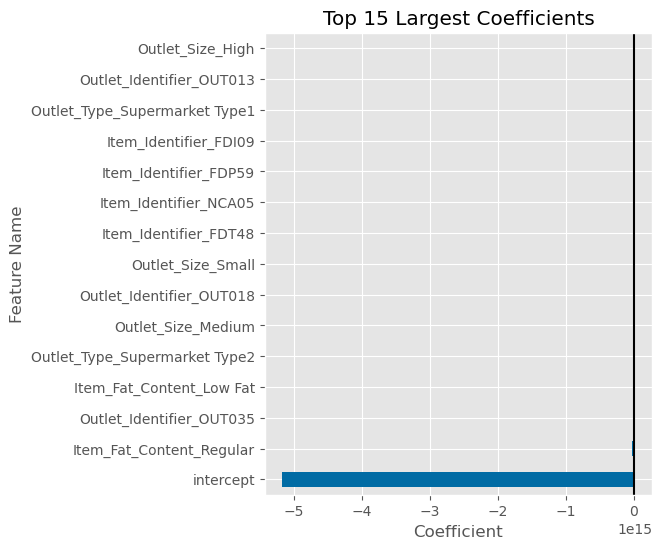

In [22]:
## sort features and keep top_n and set title
ax = coeffs_plot.sort_values().plot(kind='barh',figsize=(5,6))
ax.axvline(0,color='k');
ax.set(title = f"Top {top_n} Largest Coefficients",ylabel="Feature Name",
      xlabel='Coefficient');

## Plot coefficients with function

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

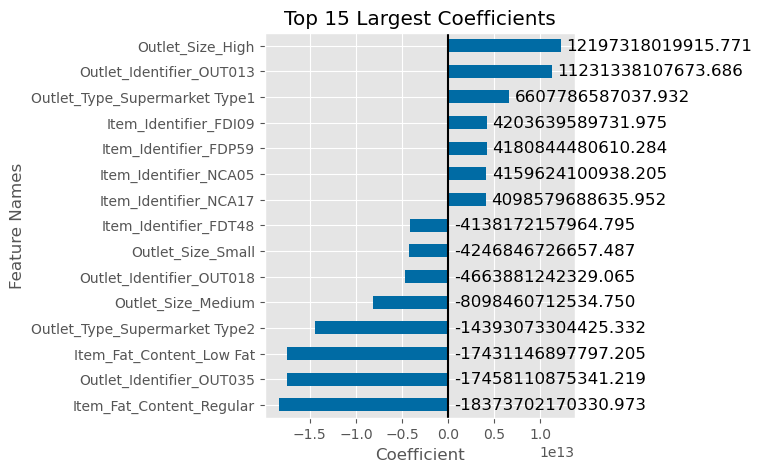

In [26]:
#function coefficients
fig=plot_coeffs(coeffs,top_n=15,intercept=False,annotate=True);
fig.savefig('Top 15(Linear Regression).png')



### Three most impactful coefficients:
- Outlet size: the size of the outlet affect grocery sales
- Outlet identifier- this is a not useful index
- Outlet type: similar to size but  differences between a grocery store and an outlet

# Random Forest Model

In [27]:
# instantiate the model, fit and evaluate
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2= 0.91	RMSE= 438.65
Test Data:	R^2= 0.37	RMSE= 1179.95


In [28]:
## Saving the coefficients
importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
importances

Item_Weight                      0.056473
Item_Visibility                  0.076990
Item_MRP                         0.544875
Outlet_Establishment_Year        0.013724
Item_Identifier_DRA12            0.000022
                                   ...   
Outlet_Location_Type_Tier 1      0.004834
Outlet_Location_Type_Tier 2      0.003335
Outlet_Location_Type_Tier 3      0.004369
Outlet_Type_Supermarket Type1    0.005275
Outlet_Type_Supermarket Type2    0.003223
Length: 1510, dtype: float64

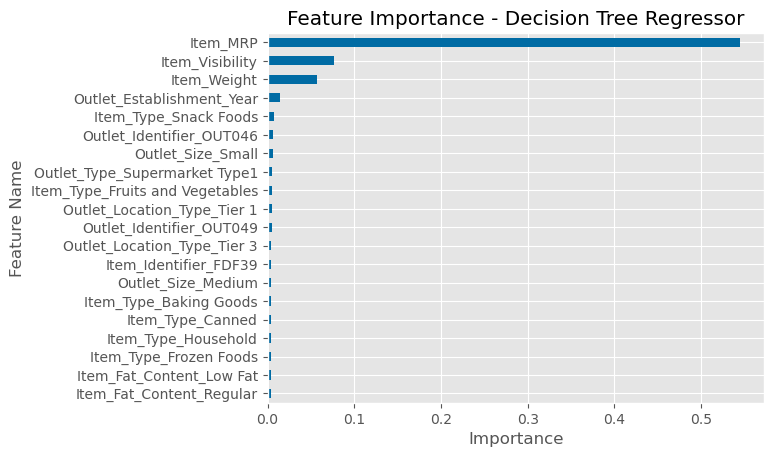

In [29]:
# Create plot
ax = importances.sort_values().tail(20).plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Decision Tree Regressor',ylabel="Feature Name",
      xlabel='Importance');

### Five most important features
- Item MRP?
- Item Visibility: The visibility affects sales
- Item weight: The weight of the item affects sales
- Outlet Year: The year the outlet was built affects sales
- Item Snack Foods: ?


In [30]:
# Save figure

# Joblib

In [31]:
# look at the head
X_train.head()


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
3527,FDQ36,7.855,Regular,0.000000,Baking Goods,38.3848,OUT046,1997,Small,Tier 1,Supermarket Type1
7331,FDT31,19.750,Low Fat,0.012499,Fruits and Vegetables,188.0872,OUT018,2009,Medium,Tier 3,Supermarket Type2
4003,DRO47,10.195,Low Fat,0.000000,Hard Drinks,114.0860,OUT046,1997,Small,Tier 1,Supermarket Type1
2737,FDA33,6.480,Low Fat,0.033900,Snack Foods,146.9076,OUT046,1997,Small,Tier 1,Supermarket Type1
3553,FDW47,15.000,Low Fat,0.046375,Breads,122.8414,OUT046,1997,Small,Tier 1,Supermarket Type1


In [32]:
# evaluate linear regression
evaluate_regression(lin_reg,X_train_df,y_train, X_test_df, y_test)

Training Data:	R^2= 0.70	RMSE= 824.30
Test Data:	R^2= -149221048598431520.00	RMSE= 572044856540.76


In [33]:
#evaluate random forest
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

Training Data:	R^2= 0.91	RMSE= 438.65
Test Data:	R^2= 0.37	RMSE= 1179.95


In [36]:
## creating a dictionary of all of the variables to save for later
best_model_joblib = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
          'RandomForestRegressor':rf_reg
         }